In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import utility

In [3]:
df = pd.read_csv("iris.data.txt", header=None)
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
y = df.iloc[0:100, 4].values # first 100 samples, of 4th column, only Iris-setosa, Iris-versicolor
y = np.where(y == "Iris-setosa", -1, 1) # Iris-setosa = -1, Iris-versicolor = 1
y.shape

(100,)

In [5]:
X = df.iloc[0:100, [0,2]].values # get only 0 and 2 column, sepal length and petal length
X.shape

(100, 2)

In [6]:
# standardize features
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

In [7]:
X_std[0:2]

array([[-0.5810659 , -1.01435952],
       [-0.89430898, -1.01435952]])

In [8]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value averaged over all
      training samples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.
        
                Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1]) # shape[1] is number of features
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
                #print(X[0:2])
                #print("X shape : ", X.shape) # X shape :  (100, 2)
            
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
                
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y)) # shuffles numbers
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1+m) # added 1 for the bias
        # now size of w_ is 1 plus number of features, w0 is bias
        #print("w initialized : ", self.w_) # w initialized :  [ 0.01624345 -0.00611756 -0.00528172]
        # this looks like a row  vector, but actually column vector
        #print("w shape ", self.w_.shape) # w size  (3,) column vector
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        #print("output ", output, " : target ", target, "  : error ", error)
        #print("xi ", xi, "   error ", error)
        #self.w_[1:] += self.eta * xi.dot(error) # <---- can we do this np.dot(xi, error)
        self.w_[1:] += self.eta * np.dot(xi, error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        #print("X ", X) # X  [0.51528486 0.78956302]
        #print("X ", X.shape)  # X  (2,)
        #print("w ", self.w_[1:].shape) # w  (2,)
        # both X and w_ are column vectors.. how dot product works.
        # np.dot is doing the transpose of X
        # this return (x1*w1 + x2*w2) + w0
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        # this is just a linear activation function
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

The weight is updated for each training sample.
- Net input : z = w0 + w1*x1 + w2*x2 + .... = w0 + np.dot(X, w[1:])
- activation function : output = phi(z) = z (linear activation function)
- error = y_true - output
- wi = wi + eta x SUM(x_i*error_i) = wi + eta x np.dot(xi, error)
- w0 = eta x SUM(error)
- cost : J = 0.5*SUM(error^2)
- predict : prediction happens at the end.

https://stackoverflow.com/questions/22994423/difference-between-np-random-seed-and-np-random-randomstate

In [9]:
# below are equivalent
np.random.seed(1234)
np.random.uniform(0, 10, 5)

array([1.9151945 , 6.22108771, 4.37727739, 7.85358584, 7.79975808])

In [10]:
rstate = np.random.RandomState(1234) # you need to save an instance of the class
rstate.uniform(0, 10, 5)

array([1.9151945 , 6.22108771, 4.37727739, 7.85358584, 7.79975808])

In [11]:
rstate.normal(loc=0.0, scale=0.01, size=10)

array([-0.00940298, -0.00956584, -0.00330607,  0.00874128,  0.0200255 ,
        0.00010862, -0.00869247,  0.01424984,  0.00145809,  0.02894091])

In [12]:
rstate.permutation(5)

array([3, 0, 2, 1, 4])

In [13]:
rstate.permutation(5)

array([4, 1, 0, 3, 2])

#### fit the dataset

In [14]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

In [15]:
X_std.shape

(100, 2)

#### Fit to standardized X_std

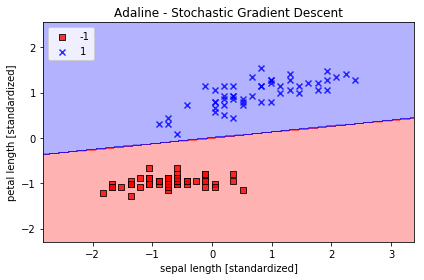

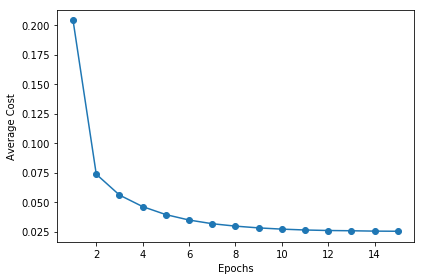

In [16]:
utility.plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('images/02_15_1.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()

In [17]:
ada.w_ # array([ 2.27202773e-04, -1.38544756e-01,  1.07263215e+00])

array([ 2.27202773e-04, -1.38544756e-01,  1.07263215e+00])

In [18]:
print(ada.cost_)

[0.20394456166031524, 0.07361591599497305, 0.05595915980120137, 0.04616048513652026, 0.039384514777334234, 0.03477977825838303, 0.031657219041863846, 0.029612965517701775, 0.02811985114187205, 0.027075165024754613, 0.026343115030327834, 0.025908993480534163, 0.025690816663739714, 0.025388179942035075, 0.025269618641442088]


#### Fit to original data X

In [19]:
ada2 = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada2.fit(X, y)

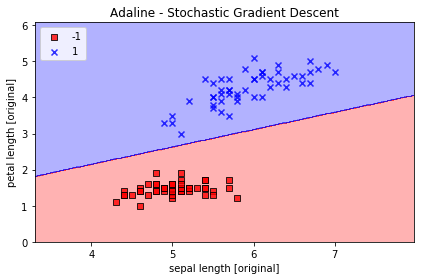

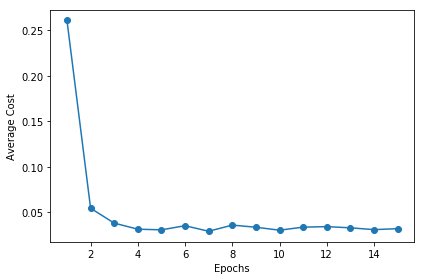

In [20]:
utility.plot_decision_regions(X, y, classifier=ada2)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [original]')
plt.ylabel('petal length [original]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('images/02_15_1.png', dpi=300)
plt.show()

plt.plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()

In [21]:
ada2.w_  # array([-0.17952732, -0.38435948,  0.79986248])

array([-0.17952732, -0.38435948,  0.79986248])

In [22]:
print(ada2.cost_)

[0.2606898405098612, 0.05444881177320337, 0.03809586786216633, 0.03146918803364327, 0.030735458770163083, 0.03528023756259725, 0.029180905384904917, 0.035948561200239836, 0.03359851342319809, 0.03035397177061938, 0.03369589676230456, 0.03426235937484071, 0.0329722635140148, 0.030962564557740636, 0.03203718247038334]
